<a href="https://colab.research.google.com/github/jaeohshin/keras/blob/main/tutorial_6_timeseries_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries data.
# In this tutirial we predict weather based on previous data using Recurrent neural network (RNN)

In [1]:
#download data and uncompress- the data is measured every 10 min.
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2023-06-07 00:33:22--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.93.246, 54.231.133.120, 54.231.201.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.93.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  28.0MB/s    in 0.5s    

2023-06-07 00:33:23 (28.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
print(lines[1:3])

['01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10', '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']


In [5]:
import numpy as np
temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


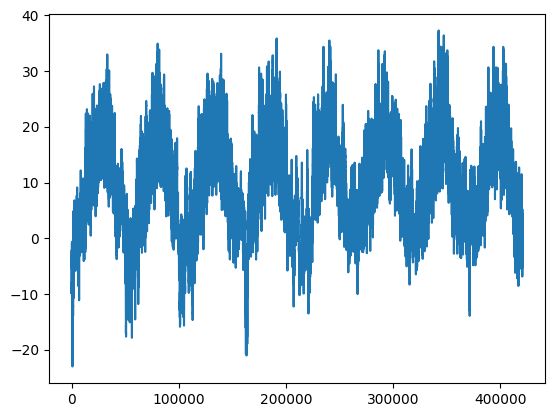

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
# The data is from 2009. Jan 1st to 2016. Dec.

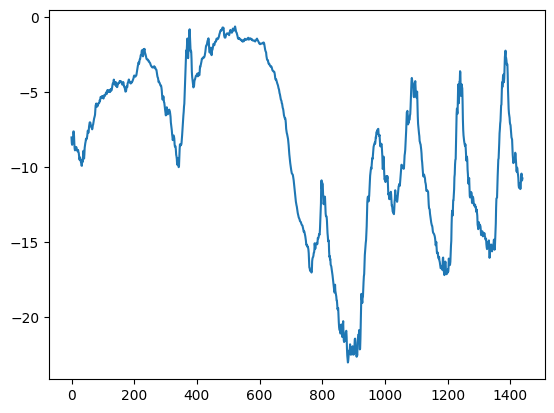

In [7]:
plt.plot(range(1440), temperature[:1440])
# 10 days of data.

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [9]:
print(num_train_samples)
print(num_val_samples)
print(num_test_samples)

210225
105112
105114


In [10]:
# Prepare the data
# Normalize the data-only using training samples

mean = raw_data[:num_train_samples].mean(axis=0) # mean of traing data
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0) # I think the order is importat.
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


# Instantiating datasets for training, validation, and testing

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1 )
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples+num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples+num_val_samples)


In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


#Common-sense baseline MAE

In [14]:
# Assume that temperature in 24 hour is the same as current temp. 0th method.

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err/ samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 4.48
Test MAE: 4.70


# Densely connected model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks
                    )

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
821/821 [==============================] - 55s 61ms/step - loss: 26.9016 - mae: 4.0934 - val_loss: 23.8986 - val_mae: 3.8892
Epoch 2/10
821/821 [==============================] - 42s 51ms/step - loss: 23.1065 - mae: 3.8120 - val_loss: 25.3808 - val_mae: 4.0133
Epoch 3/10
821/821 [==============================] - 49s 59ms/step - loss: 22.4779 - mae: 3.7630 - val_loss: 23.1558 - val_mae: 3.8481
Epoch 4/10
821/821 [==============================] - 50s 61ms/step - loss: 22.0032 - mae: 3.7274 - val_loss: 23.7828 - val_mae: 3.8918
Epoch 5/10
821/821 [==============================] - 49s 59ms/step - loss: 21.7521 - mae: 3.7063 - val_loss: 25.0257 - val_mae: 4.0000
Epoch 6/10
821/821 [==============================] - 41s 50ms/step - loss: 21.4668 - mae: 3.6838 - val_loss: 23.7925 - val_mae: 3.9023
Epoch 7/10
821/821 [==============================] - 49s 59ms/step - loss: 21.3186 - mae: 3.6707 - val_loss: 25.0054 - val_mae: 3.9872
Epoch 8/10
821/821 [============================

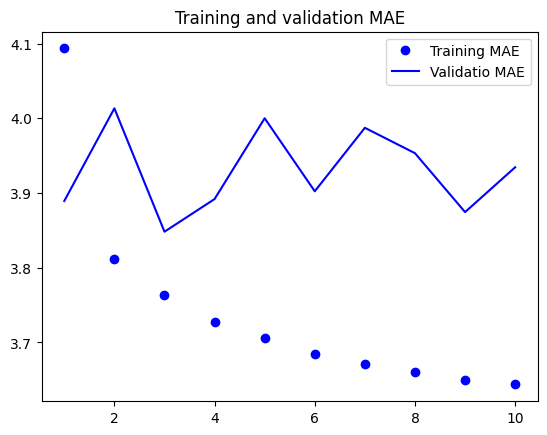

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validatio MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()